This is one of submissions on "Journey to Springfield" task from Deep Learning School course. Overall score 0.98

In [3]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
#!pip uninstall -y Pillow
#!pip install Pillow
import PIL
print(PIL.__version__)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

9.5.0


In [8]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Jun  9 17:12:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [9]:
import pickle
import numpy as np
#from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [10]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Below, we use a wrapper over the dataset for more convenient handling. It's important to understand what's happening with the LabelEncoder and torch.Transform.

ToTensor converts a PIL Image with values in the range [0, 255] (as pixel values typically are) into a FloatTensor of shape (C x H x W) in the range [0, 1]. After that, normalization is applied using the formula:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       The constants (mean and standard deviation) are based on ImageNet channel-wise statistics.


It's also worth noting that we override the __getitem__ method to work more conveniently with this data structure.

Additionally, LabelEncoder is used to convert string class labels to numeric IDs and vice versa. According to the dataset description, images come in different sizes (as they were extracted directly from videos), so we bring them to a uniform size using the _prepare_sample method.

The total number of images: 20933


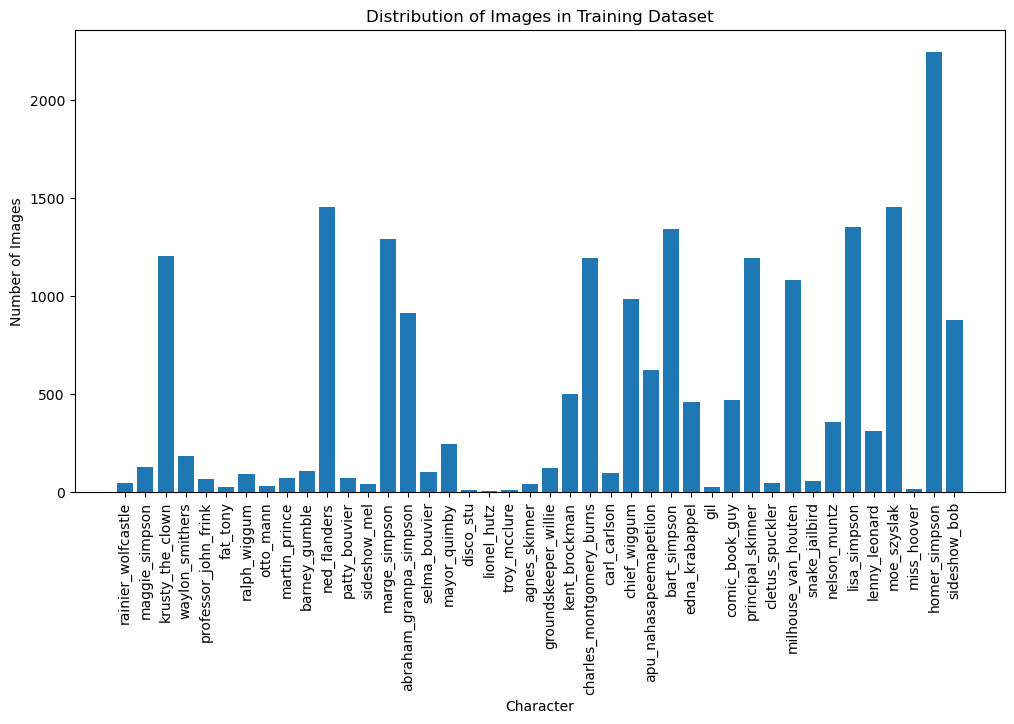

In [11]:
import os
import matplotlib.pyplot as plt

def get_class_distribution(dataset_folder):
    class_counts = {}
    total_images = 0
    for class_name in os.listdir(dataset_folder):
        class_path = os.path.join(dataset_folder, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
            total_images += num_images
    return class_counts, total_images

training_folder = '/kaggle/input/journey-springfield/train/simpsons_dataset' 
class_distribution, total_images = get_class_distribution(training_folder)

print("The total number of images:", total_images)

# Plotting the distribution
class_names = list(class_distribution.keys())
class_counts = list(class_distribution.values())

plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts)
plt.xlabel('Character')
plt.ylabel('Number of Images')
plt.title('Distribution of Images in Training Dataset')
plt.xticks(rotation=90)
plt.show()

In [12]:
minority_threshold = 500  # Define the threshold for the minority classes

minority_classes = [class_name for class_name, count in zip(class_names, class_counts) if count < minority_threshold]
print("Minority classes:", minority_classes)

Minority classes: ['rainier_wolfcastle', 'maggie_simpson', 'waylon_smithers', 'professor_john_frink', 'fat_tony', 'ralph_wiggum', 'otto_mann', 'martin_prince', 'barney_gumble', 'patty_bouvier', 'sideshow_mel', 'selma_bouvier', 'mayor_quimby', 'disco_stu', 'lionel_hutz', 'troy_mcclure', 'agnes_skinner', 'groundskeeper_willie', 'kent_brockman', 'carl_carlson', 'edna_krabappel', 'gil', 'comic_book_guy', 'cletus_spuckler', 'snake_jailbird', 'nelson_muntz', 'lenny_leonard', 'miss_hoover']


**We can see that many classes have very few images. Therefore, we apply different transforms to different classes. This is called Data Augmentation.**

# SimpsonsDataset 

In [14]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode, minority_classes=None):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()
        
        self.minority_classes = minority_classes

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    def __getitem__(self, index):
        
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = Image.fromarray(x)

        if self.mode == 'train':
            minority_augmentation = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

            majority_augmentation = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()

            # Check if the sample belongs to a minority class
            if y in self.minority_classes:
                # Apply minority class augmentation
                x = minority_augmentation(x)
            else:
                # Apply majority class augmentation
                x = majority_augmentation(x)
        else:
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

            x = transform(x)

        if self.mode == 'test':
            return x
        elif self.mode == 'val':
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        else:
            return x, y

        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [15]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [16]:
TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [17]:
#test_files

In [18]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
'''train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)'''
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels, shuffle=True)

In [19]:
val_dataset = SimpsonsDataset(val_files, mode='val', minority_classes=minority_classes)

Давайте посмотрим на наших героев внутри датасета.

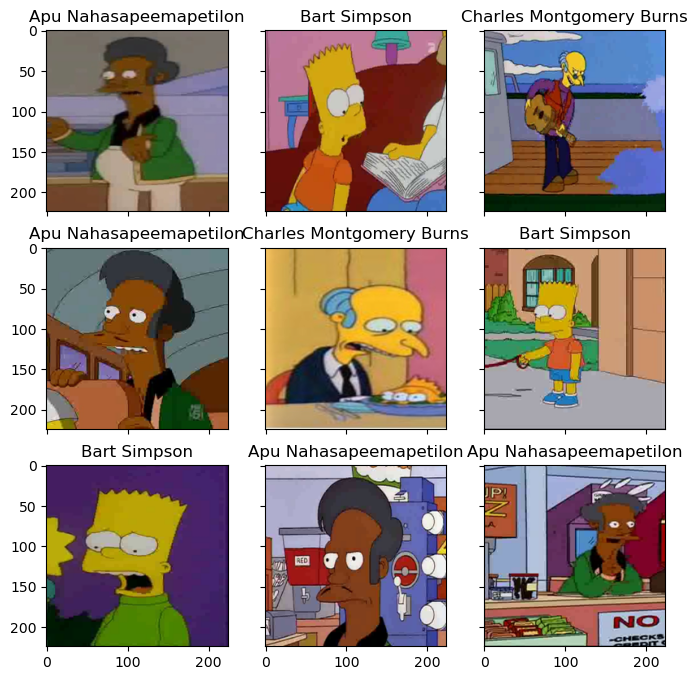

In [21]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Constracting Neural Network

**Here is the model I built, based on Simple_CNN and AlexNet.**


In [22]:
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__() 
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(8, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(96 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, n_classes),
        )

    def forward(self, x):
        x = self.features(x)
        #print(x.shape)
        x = self.avgpool(x)
        #print(x.shape)
        x = x.view(x.size(0), 96 * 6 * 6)
        logits = self.classifier(x)
        return logits

In [23]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [24]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.005)
        criterion = nn.CrossEntropyLoss()

        # Create a scheduler. ReduceLROnPlateau is a good baseline
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3, verbose=True)

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            # Step the scheduler based on the validation loss
            scheduler.step(val_loss)

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    
    return history

In [26]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [27]:
n_classes = len(np.unique(train_val_labels))
alex_net = AlexNet(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(alex_net)

we will classify :42
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14)

In [28]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val', minority_classes=minority_classes)
    
train_dataset = SimpsonsDataset(train_files, mode='train', minority_classes=minority_classes)

In [29]:
history = train(train_dataset, val_dataset, model=alex_net, epochs=30, batch_size=32)

epoch:   3%|▎         | 1/30 [04:25<2:08:16, 265.38s/it]


Epoch 001 train_loss: 2.6888 val_loss 2.0998 train_acc 0.2463 val_acc 0.4352


epoch:   7%|▋         | 2/30 [07:14<1:37:24, 208.72s/it]


Epoch 002 train_loss: 2.1011 val_loss 1.5924 train_acc 0.4249 val_acc 0.5606


epoch:  10%|█         | 3/30 [10:04<1:26:00, 191.13s/it]


Epoch 003 train_loss: 1.7703 val_loss 1.3467 train_acc 0.5119 val_acc 0.6400


epoch:  13%|█▎        | 4/30 [12:56<1:19:29, 183.45s/it]


Epoch 004 train_loss: 1.5558 val_loss 1.1597 train_acc 0.5704 val_acc 0.6813


epoch:  17%|█▋        | 5/30 [15:46<1:14:24, 178.57s/it]


Epoch 005 train_loss: 1.3965 val_loss 1.0026 train_acc 0.6132 val_acc 0.7289


epoch:  20%|██        | 6/30 [18:35<1:10:05, 175.24s/it]


Epoch 006 train_loss: 1.2894 val_loss 0.9334 train_acc 0.6395 val_acc 0.7430


epoch:  23%|██▎       | 7/30 [21:21<1:06:06, 172.45s/it]


Epoch 007 train_loss: 1.1788 val_loss 0.8538 train_acc 0.6688 val_acc 0.7715


epoch:  27%|██▋       | 8/30 [24:09<1:02:41, 170.96s/it]


Epoch 008 train_loss: 1.0945 val_loss 0.7551 train_acc 0.6927 val_acc 0.7906


epoch:  30%|███       | 9/30 [26:56<59:23, 169.70s/it]


Epoch 009 train_loss: 1.0382 val_loss 0.7528 train_acc 0.7085 val_acc 0.7963


epoch:  33%|███▎      | 10/30 [29:41<56:07, 168.40s/it]


Epoch 010 train_loss: 0.9902 val_loss 0.7234 train_acc 0.7209 val_acc 0.8032


epoch:  37%|███▋      | 11/30 [32:26<52:59, 167.33s/it]


Epoch 011 train_loss: 0.9226 val_loss 0.6612 train_acc 0.7394 val_acc 0.8246


epoch:  40%|████      | 12/30 [35:10<49:52, 166.27s/it]


Epoch 012 train_loss: 0.8948 val_loss 0.6605 train_acc 0.7480 val_acc 0.8175


epoch:  43%|████▎     | 13/30 [37:54<46:55, 165.62s/it]


Epoch 013 train_loss: 0.8399 val_loss 0.6240 train_acc 0.7639 val_acc 0.8370


epoch:  47%|████▋     | 14/30 [40:39<44:04, 165.26s/it]


Epoch 014 train_loss: 0.8092 val_loss 0.5852 train_acc 0.7719 val_acc 0.8483


epoch:  50%|█████     | 15/30 [43:23<41:14, 164.95s/it]


Epoch 015 train_loss: 0.7794 val_loss 0.5658 train_acc 0.7796 val_acc 0.8483


epoch:  53%|█████▎    | 16/30 [46:08<38:27, 164.84s/it]


Epoch 016 train_loss: 0.7324 val_loss 0.5878 train_acc 0.7923 val_acc 0.8424


epoch:  57%|█████▋    | 17/30 [48:52<35:40, 164.66s/it]


Epoch 017 train_loss: 0.7138 val_loss 0.5830 train_acc 0.7978 val_acc 0.8458


epoch:  60%|██████    | 18/30 [51:37<32:56, 164.73s/it]


Epoch 018 train_loss: 0.6803 val_loss 0.5728 train_acc 0.8081 val_acc 0.8466


epoch:  63%|██████▎   | 19/30 [54:23<30:18, 165.28s/it]


Epoch 019 train_loss: 0.6497 val_loss 0.5634 train_acc 0.8192 val_acc 0.8546


epoch:  67%|██████▋   | 20/30 [57:10<27:36, 165.64s/it]


Epoch 020 train_loss: 0.6466 val_loss 0.5155 train_acc 0.8143 val_acc 0.8735


epoch:  70%|███████   | 21/30 [59:54<24:46, 165.16s/it]


Epoch 021 train_loss: 0.6206 val_loss 0.5101 train_acc 0.8247 val_acc 0.8705


epoch:  73%|███████▎  | 22/30 [1:02:37<21:57, 164.64s/it]


Epoch 022 train_loss: 0.6247 val_loss 0.5532 train_acc 0.8267 val_acc 0.8603


epoch:  77%|███████▋  | 23/30 [1:05:20<19:09, 164.22s/it]


Epoch 023 train_loss: 0.5863 val_loss 0.5505 train_acc 0.8341 val_acc 0.8655


epoch:  80%|████████  | 24/30 [1:08:03<16:22, 163.71s/it]


Epoch 024 train_loss: 0.5794 val_loss 0.5086 train_acc 0.8352 val_acc 0.8678


epoch:  83%|████████▎ | 25/30 [1:10:46<13:38, 163.63s/it]


Epoch 025 train_loss: 0.5663 val_loss 0.5347 train_acc 0.8405 val_acc 0.8668


epoch:  87%|████████▋ | 26/30 [1:13:30<10:54, 163.69s/it]


Epoch 026 train_loss: 0.5511 val_loss 0.5443 train_acc 0.8435 val_acc 0.8716


epoch:  90%|█████████ | 27/30 [1:16:13<08:10, 163.42s/it]


Epoch 027 train_loss: 0.5540 val_loss 0.5493 train_acc 0.8466 val_acc 0.8663


epoch:  93%|█████████▎| 28/30 [1:18:57<05:27, 163.71s/it]

Epoch 00028: reducing learning rate of group 0 to 1.0000e-05.

Epoch 028 train_loss: 0.5311 val_loss 0.5443 train_acc 0.8469 val_acc 0.8716


epoch:  97%|█████████▋| 29/30 [1:21:42<02:43, 163.92s/it]


Epoch 029 train_loss: 0.4692 val_loss 0.4862 train_acc 0.8711 val_acc 0.8869


epoch: 100%|██████████| 30/30 [1:24:28<00:00, 168.96s/it]


Epoch 030 train_loss: 0.4351 val_loss 0.4918 train_acc 0.8763 val_acc 0.8882


In [30]:
loss, acc, val_loss, val_acc = zip(*history)

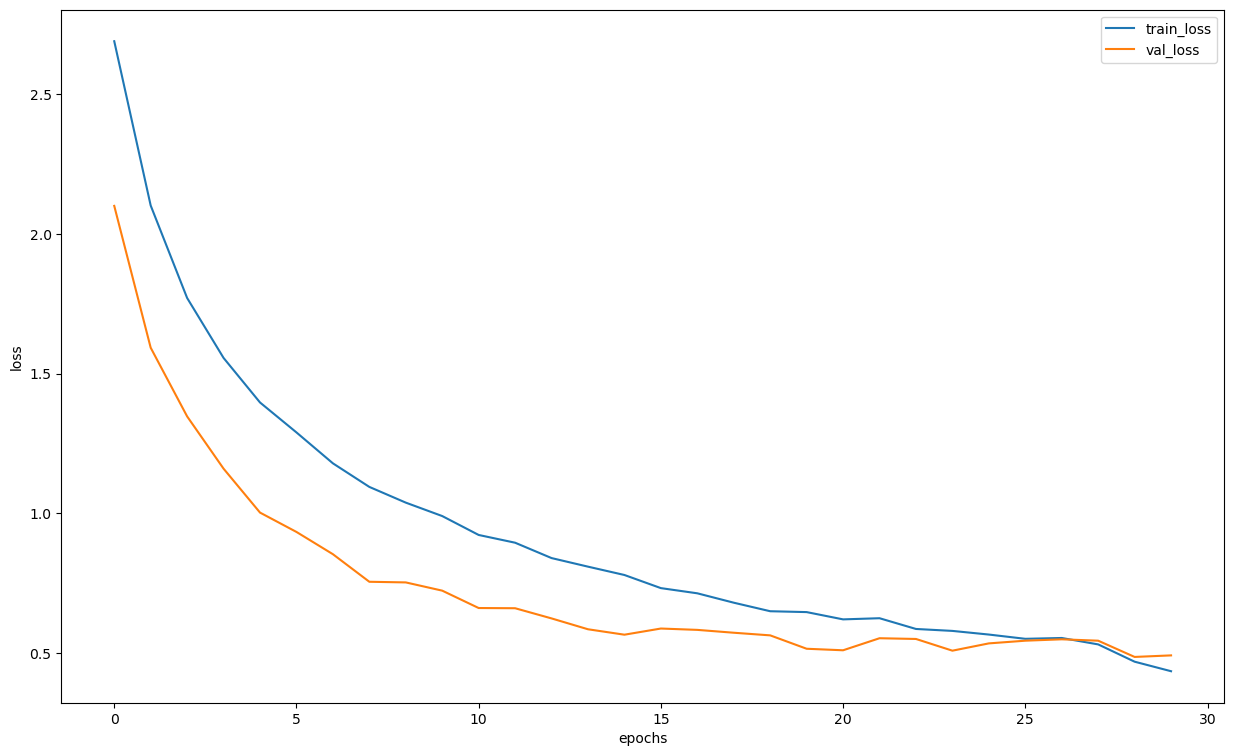

In [31]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [32]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [33]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(alex_net, ex_img.unsqueeze(0))

In [34]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(alex_net, imgs)

In [35]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [36]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

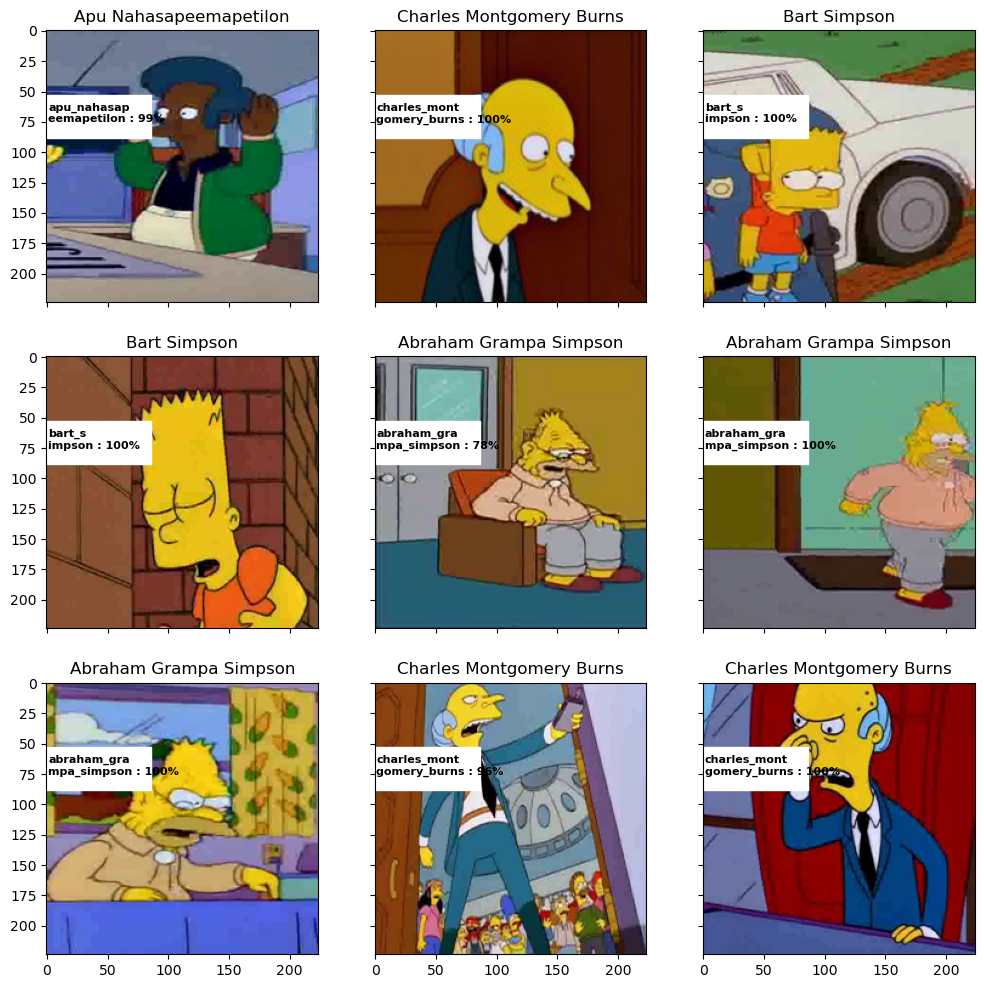

In [37]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(alex_net, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [38]:
test_dataset = SimpsonsDataset(test_files, mode="test", minority_classes=minority_classes)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(alex_net, test_loader)
#preds = np.argmax(probs, axis=1)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [40]:
import os 
os.remove("/kaggle/working/label_encoder.pkl")

In [41]:
import pandas as pd
#my_submit = pd.read_csv("/content/sample_submission.csv")
submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
#submit.sort_values(by=['Image_id'])
submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
submit.to_csv('submission.csv', index=False)